This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, spm   
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
%matplotlib inline
import matplotlib.pyplot as plt

datadir='/home/vagrant/data/ds000114_R2.0.1/'
    
results_dir = os.path.abspath("../../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

Using data from /home/vagrant/data/ds000114_R2.0.1/


/home/vagrant/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from bids.grabbids import BIDSLayout
layout = BIDSLayout(datadir)
layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[0].filename

'/home/vagrant/data/ds000114_R2.0.1/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz'

In [3]:
import pandas as pd
events = pd.read_csv(os.path.join(datadir, "task-fingerfootlips_events.tsv"), sep="\t")
events

onset  duration  weight trial_type
0      10      15.0       1     Finger
1      40      15.0       1       Foot
2      70      15.0       1       Lips
3     100      15.0       1     Finger
4     130      15.0       1       Foot
5     160      15.0       1       Lips
6     190      15.0       1     Finger
7     220      15.0       1       Foot
8     250      15.0       1       Lips
9     280      15.0       1     Finger
10    310      15.0       1       Foot
11    340      15.0       1       Lips
12    370      15.0       1     Finger
13    400      15.0       1       Foot
14    430      15.0       1       Lips

In [4]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

    onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger
    onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot
    onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips


In [5]:
events[events.trial_type == 'Finger'].duration

0     15.0
3     15.0
6     15.0
9     15.0
12    15.0
Name: duration, dtype: float64

In [13]:
source_epi = layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[5]

confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_confounds.tsv"%(source_epi.subject,
                                                                                                                           source_epi.session)),
           sep="\t", na_values="n/a")

info = [Bunch(conditions=['Finger',
                          'Foot',
                          'Lips'],
              onsets=[list(events[events.trial_type == 'Finger'].onset-10),
                      list(events[events.trial_type == 'Foot'].onset-10),
                      list(events[events.trial_type == 'Lips'].onset-10)],
              durations=[list(events[events.trial_type == 'Finger'].duration),
                          list(events[events.trial_type == 'Foot'].duration),
                          list(events[events.trial_type == 'Lips'].duration)],
             regressors=[list(confounds.FramewiseDisplacement.fillna(0)[4:]),
                         list(confounds.aCompCor0[4:]),
                         list(confounds.aCompCor1[4:]),
                         list(confounds.aCompCor2[4:]),
                         list(confounds.aCompCor3[4:]),
                         list(confounds.aCompCor4[4:]),
                         list(confounds.aCompCor5[4:]),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor0',
                              'aCompCor1',
                              'aCompCor2',
                              'aCompCor3',
                              'aCompCor4',
                              'aCompCor5'],
              amplitudes=None,
              tmod=None,
              pmod=None)
       ]

skip = mem.cache(fsl.ExtractROI)
skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"%(source_epi.subject,
                                                                                                                           source_epi.session)),
                     t_min=4, t_size=-1, output_type="NIFTI")
s = model.SpecifySPMModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = skip_results.outputs.roi_file
s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.concatenate_runs=False
s.inputs.output_units='secs'
s.inputs.subject_info = info
specify_model_results = s.run()
specify_model_results.outputs

170216-18:24:41,205 workflow INFO:
	 Executing node 90e73a4efdfb9677c5c883f59a536b34 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/90e73a4efdfb9677c5c883f59a536b34
170216-18:24:41,215 workflow INFO:



session_info = [{'cond': [{'name': 'Finger', 'duration': [15.0, 15.0, 15.0, 15.0, 15.0], 'onset': [0.0, 90.0, 180.0, 270.0, 360.0]}, {'name': 'Foot', 'duration': [15.0, 15.0, 15.0, 15.0, 15.0], 'onset': [30.0, 120.0, 210.0, 300.0, 390.0]}, {'name': 'Lips', 'duration': [15.0, 15.0, 15.0, 15.0, 15.0], 'onset': [60.0, 150.0, 240.0, 330.0, 420.0]}], 'hpf': 128.0, 'regress': [{'name': 'FramewiseDisplacement', 'val': [0.16517459999999987, 0.16393550000000012, 0.060880000000000101, 0.099227999999999969, 0.092637999999999998, 0.058773500000000013, 0.08213899999999992, 0.07065919999999988, 0.059915799999999887, 0.040129600000000071, 0.087915000000000007, 0.53722140000000007, 0.37261459999999996, 0.15609944999999992, 0.20615815000000001, 0.11306650000000006, 0.78650280000000006, 0.33794455000000001, 0.19718554999999999, 0.081222700000000064, 0.047395350000000003, 0.070689999999999906, 0.054125800000000064, 0.15142230000000007, 0.044283699999999912, 0.10846885000000006, 0.13043414999999989, 0.11

In [14]:
finger_cond = ['Finger','T', ['Finger'],[1]]
foot_cond = ['Foot','T', ['Foot'],[1]]
lips_cond = ['Lips','T', ['Lips'],[1]]
lips_vs_others = ["Lips vs. others",'T', ['Finger', 'Foot', 'Lips'],[-0.5, -0.5, 1]]
all_motor = ["All motor", 'F', [finger_cond, foot_cond, lips_cond]]

contrasts=[finger_cond, foot_cond, lips_cond, lips_vs_others, all_motor]
    
matlab_cmd = '/home/vagrant/spm12/run_spm12.sh /home/vagrant/mcr/v85/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

level1design = mem.cache(spm.model.Level1Design)
level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                    bases = {'hrf':{'derivs': [0,0]}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations='AR(1)',
                                    timing_units='secs')

level1design_results.outputs

170216-18:24:42,653 workflow INFO:
	 Executing node d0fc8acdda948ce663ee87e3deb334c7 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-Level1Design/d0fc8acdda948ce663ee87e3deb334c7
170216-18:24:42,668 workflow INFO:



spm_mat_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-Level1Design/d0fc8acdda948ce663ee87e3deb334c7/SPM.mat

In [15]:
estimatemodel = mem.cache(spm.model.EstimateModel)
estimatemodel = estimatemodel(estimation_method={'Classical': 1}, 
                              spm_mat_file=level1design_results.outputs.spm_mat_file)
estimatemodel.outputs

170216-18:24:44,594 workflow INFO:
	 Executing node eeceacdf058c01cd9b67720165f53474 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474
170216-18:24:44,598 workflow INFO:



RPVimage = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/RPV.nii
beta_images = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/beta_0001.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/beta_0002.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/beta_0003.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/beta_0004.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/eeceacdf058c01cd9b67720165f53474/beta_0005.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype

In [16]:
estimatecontrasts = mem.cache(spm.model.EstimateContrast)
estimatecontrasts = estimatecontrasts(contrasts=contrasts,
                                      spm_mat_file=estimatemodel.outputs.spm_mat_file,
                                      beta_images=estimatemodel.outputs.beta_images,
                                      residual_image=estimatemodel.outputs.residual_image)
estimatecontrasts.outputs

170216-18:24:45,525 workflow INFO:
	 Executing node 4b2ee7cf0f93c6e576f9d3fc13948665 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665



con_images = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/con_0001.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/con_0002.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/con_0003.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/con_0004.nii', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/ess_0005.nii']
ess_images = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/4b2ee7cf0f93c6e576f9d3fc13948665/ess_0005.nii
spmF_images = /home/vagrant/fmri-analys

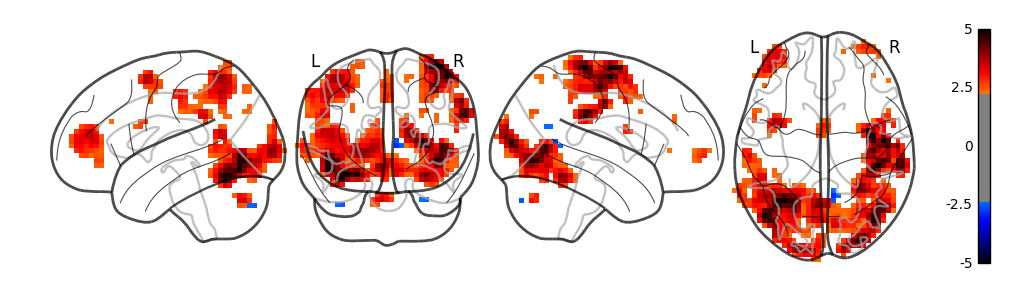

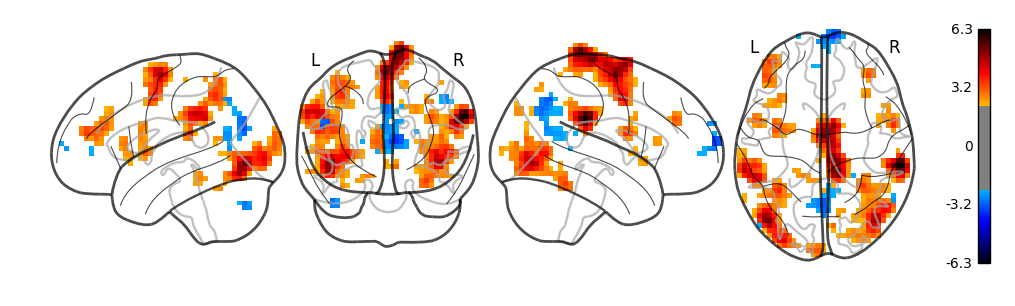

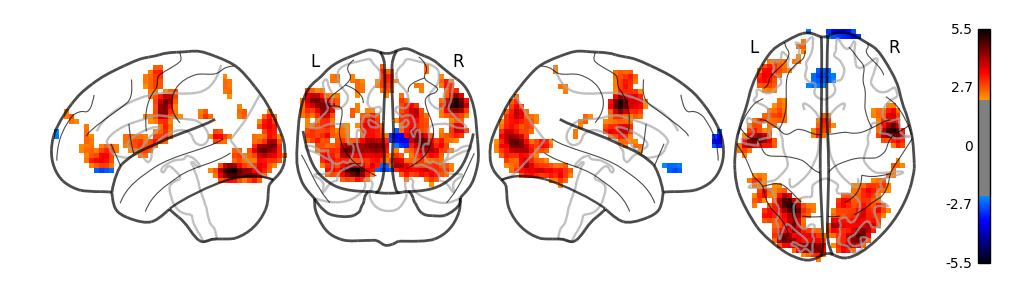

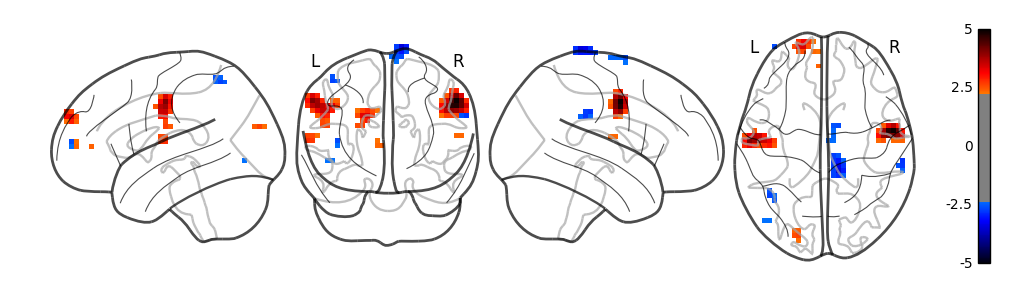

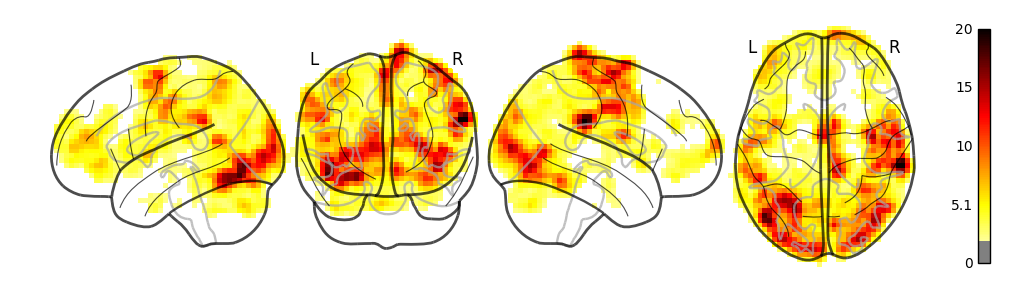

In [17]:
for con_image in estimatecontrasts.outputs.spmT_images:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(con_image, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

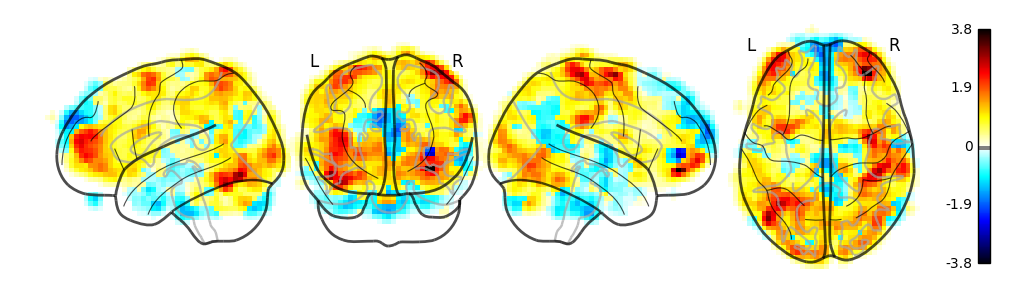

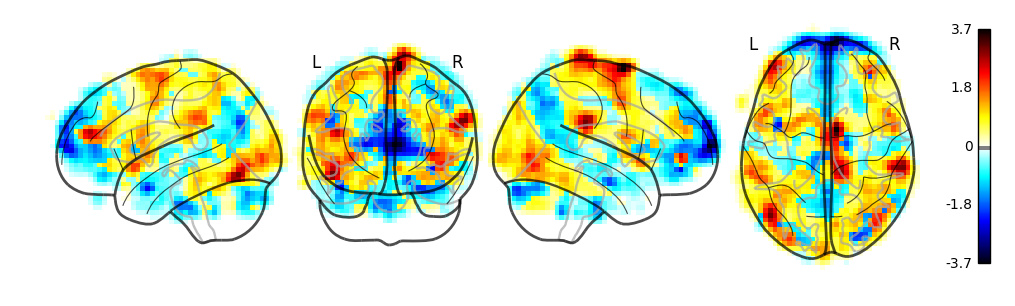

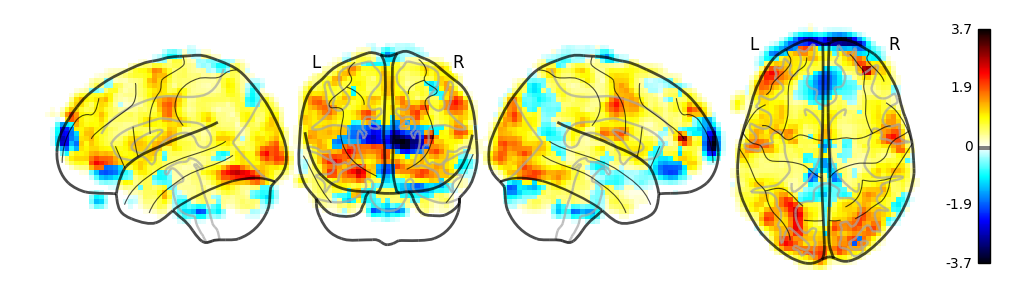

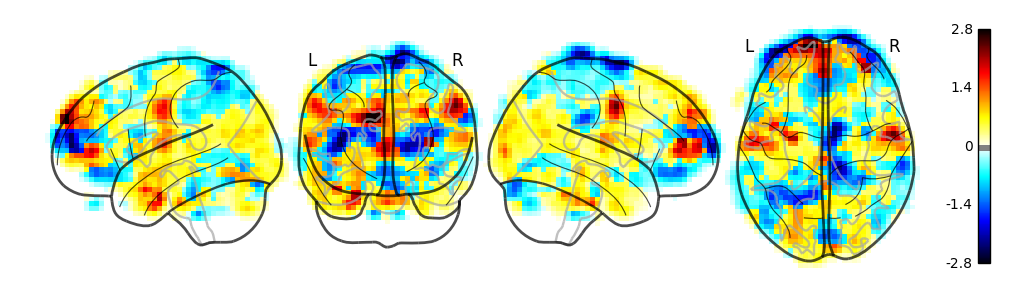

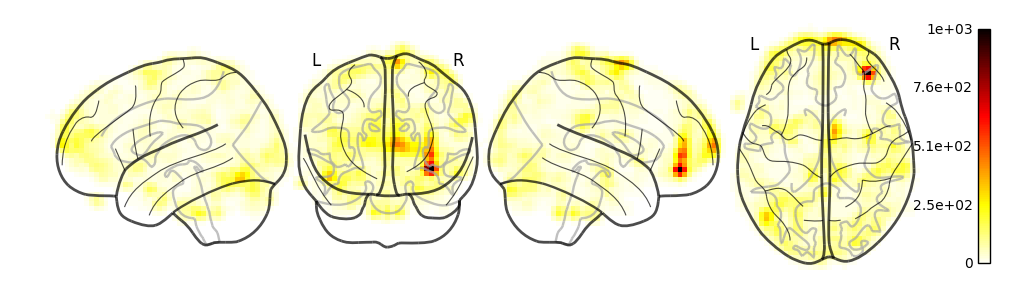

In [18]:
for con_image in estimatecontrasts.outputs.con_images:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(con_image, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False)

In [19]:
copes = {}
for i in range(10):
    source_epi = layout.get(type="bold", task="fingerfootlips", session="test", extensions="nii.gz")[i]

    confounds = pd.read_csv(os.path.join(datadir, "derivatives", "fmriprep", 
                                         "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                         "sub-%s_ses-%s_task-fingerfootlips_bold_confounds.tsv"%(source_epi.subject,
                                                                                                                               source_epi.session)),
               sep="\t", na_values="n/a")

    info = [Bunch(conditions=['Finger',
                              'Foot',
                              'Lips'],
                  onsets=[list(events[events.trial_type == 'Finger'].onset-10),
                          list(events[events.trial_type == 'Foot'].onset-10),
                          list(events[events.trial_type == 'Lips'].onset-10)],
                  durations=[list(events[events.trial_type == 'Finger'].duration),
                              list(events[events.trial_type == 'Foot'].duration),
                              list(events[events.trial_type == 'Lips'].duration)],
                 regressors=[list(confounds.FramewiseDisplacement.fillna(0)[4:]),
                             list(confounds.aCompCor0[4:]),
                             list(confounds.aCompCor1[4:]),
                             list(confounds.aCompCor2[4:]),
                             list(confounds.aCompCor3[4:]),
                             list(confounds.aCompCor4[4:]),
                             list(confounds.aCompCor5[4:]),
                            ],
                 regressor_names=['FramewiseDisplacement',
                                  'aCompCor0',
                                  'aCompCor1',
                                  'aCompCor2',
                                  'aCompCor3',
                                  'aCompCor4',
                                  'aCompCor5'],
                  amplitudes=None,
                  tmod=None,
                  pmod=None)
           ]

    skip = mem.cache(fsl.ExtractROI)
    skip_results = skip(in_file=os.path.join(datadir, "derivatives", "fmriprep", 
                                            "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
                                            "sub-%s_ses-%s_task-fingerfootlips_bold_space-MNI152NLin2009cAsym_preproc.nii.gz"%(source_epi.subject,
                                                                                                                               source_epi.session)),
                         t_min=4, t_size=-1, output_type="NIFTI")
    s = model.SpecifySPMModel()
    s.inputs.input_units = 'secs'
    s.inputs.functional_runs = skip_results.outputs.roi_file
    s.inputs.time_repetition = layout.get_metadata(source_epi.filename)["RepetitionTime"]
    s.inputs.high_pass_filter_cutoff = 128.
    s.inputs.concatenate_runs=False
    s.inputs.output_units='secs'
    s.inputs.subject_info = info
    specify_model_results = s.run()
    
    finger_cond = ['Finger','T', ['Finger'],[1]]
    foot_cond = ['Foot','T', ['Foot'],[1]]
    lips_cond = ['Lips','T', ['Lips'],[1]]
    lips_vs_others = ["Lips vs. others",'T', ['Finger', 'Foot', 'Lips'],[-0.5, -0.5, 1]]
    all_motor = ["All motor", 'F', [finger_cond, foot_cond, lips_cond]]

    contrasts=[finger_cond, foot_cond, lips_cond, lips_vs_others, all_motor]

    matlab_cmd = '/home/vagrant/spm12/run_spm12.sh /home/vagrant/mcr/v85/ script'
    spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

    level1design = mem.cache(spm.model.Level1Design)
    level1design_results = level1design(interscan_interval = layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                        bases = {'hrf':{'derivs': [1,1]}},
                                        session_info = specify_model_results.outputs.session_info,
                                        model_serial_correlations='AR(1)',
                                        timing_units='secs')
    
    estimatemodel = mem.cache(spm.model.EstimateModel)
    estimatemodel = estimatemodel(estimation_method={'Classical': 1}, 
                                  spm_mat_file=level1design_results.outputs.spm_mat_file)
    
    estimatecontrasts = mem.cache(spm.model.EstimateContrast)
    estimatecontrasts = estimatecontrasts(contrasts=contrasts,
                                          spm_mat_file=estimatemodel.outputs.spm_mat_file,
                                          beta_images=estimatemodel.outputs.beta_images,
                                          residual_image=estimatemodel.outputs.residual_image)
    
    copes[source_epi.subject] = list(estimatecontrasts.outputs.con_images)

170216-18:32:44,709 workflow INFO:
	 Executing node 2359f664e9b150aad79ffa88c75e2a1f in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/2359f664e9b150aad79ffa88c75e2a1f
170216-18:32:44,720 workflow INFO:
170216-18:32:44,749 workflow INFO:
	 Executing node bd8e0f27048667f9169fee892c21477c in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-Level1Design/bd8e0f27048667f9169fee892c21477c
170216-18:33:36,289 workflow INFO:
	 Executing node 4d680b751ece7961f835ef78a478d0a9 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateModel/4d680b751ece7961f835ef78a478d0a9
170216-18:34:43,202 workflow INFO:
	 Executing node 1decaa5e1b49d020294b23111867886e in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-spm-model-EstimateContrast/1decaa5e1b49d020294b23111867886e
170216-18:35:43,495 workflow INFO:
	 Executing

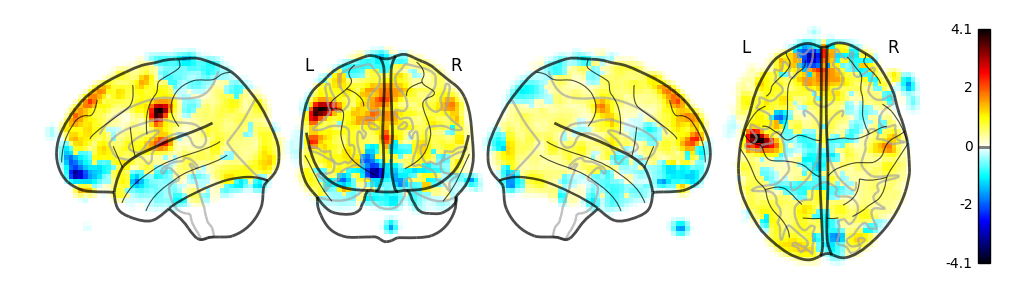

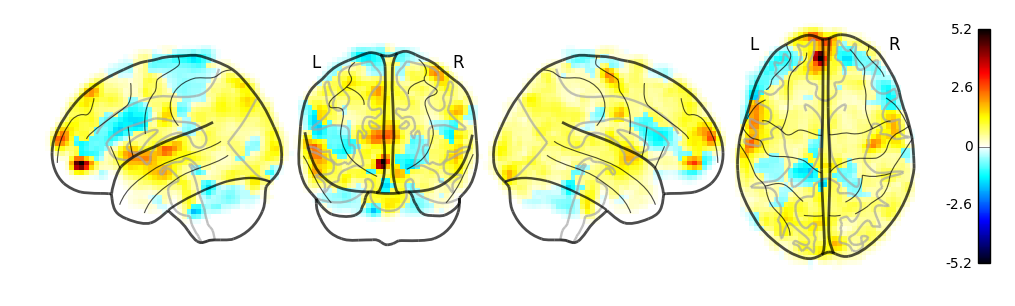

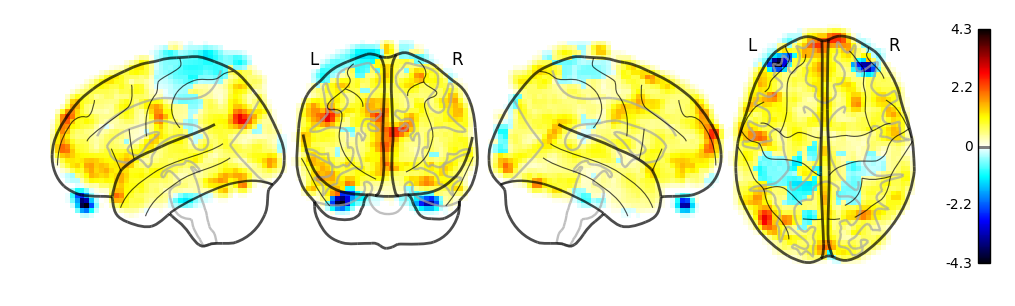

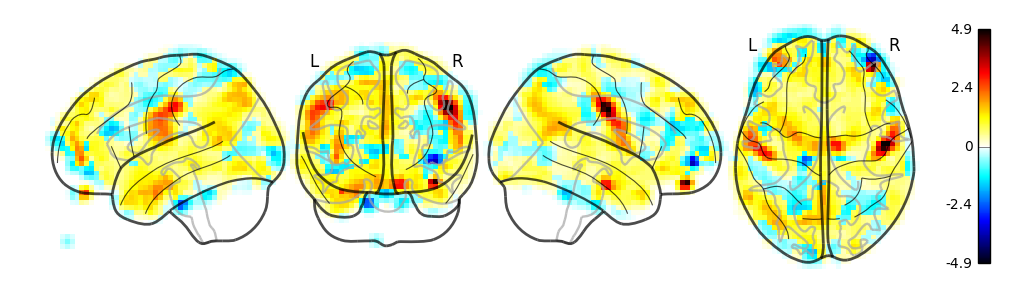

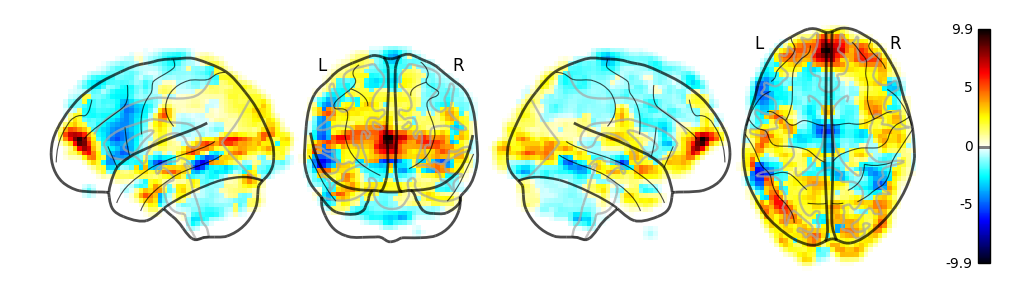

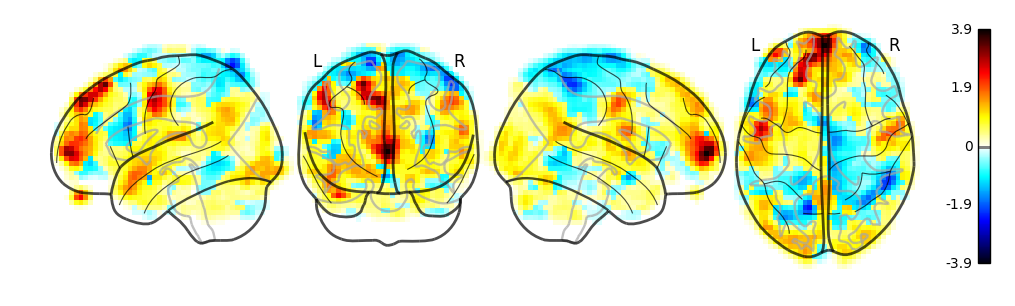

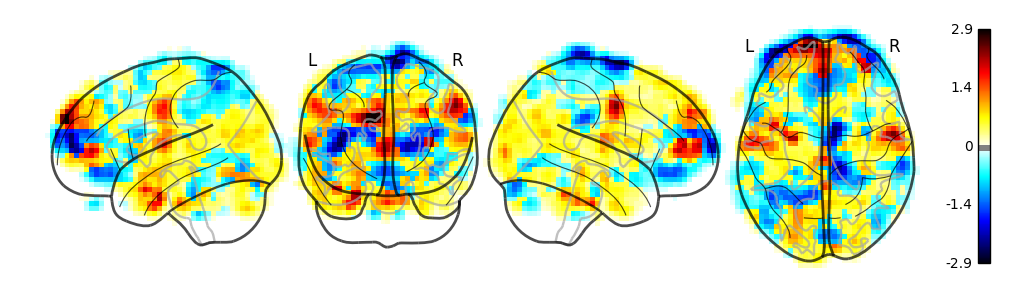

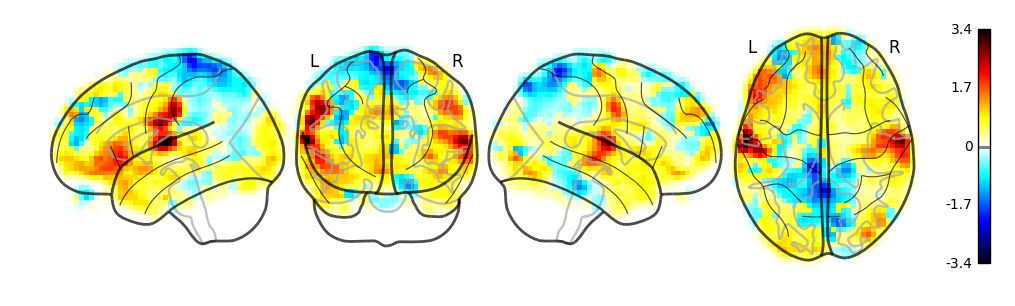

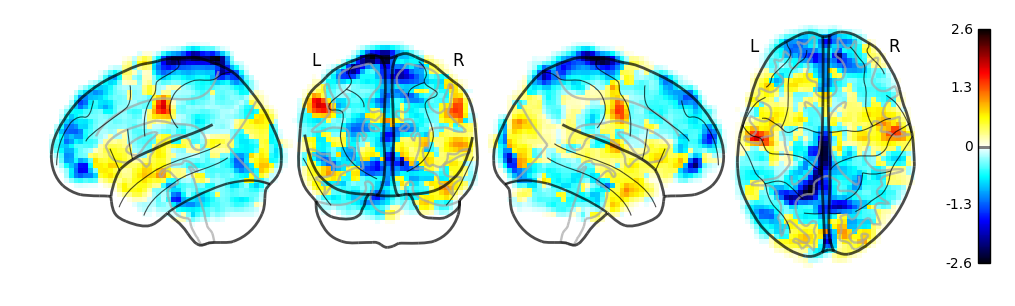

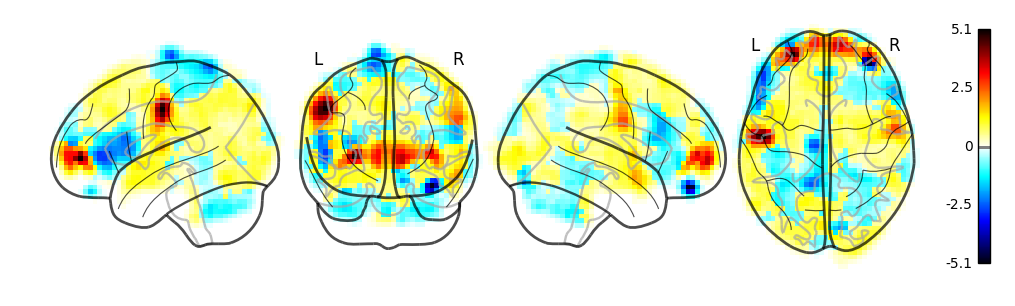

In [21]:
smooth_copes = []
for k,v in copes.items():
    smooth_cope = nilearn.image.smooth_img(v[3], 8)
    smooth_copes.append(smooth_cope)
    nilearn.plotting.plot_glass_brain(smooth_cope,
                                      display_mode='lyrz', 
                                      colorbar=True, 
                                      plot_abs=False)

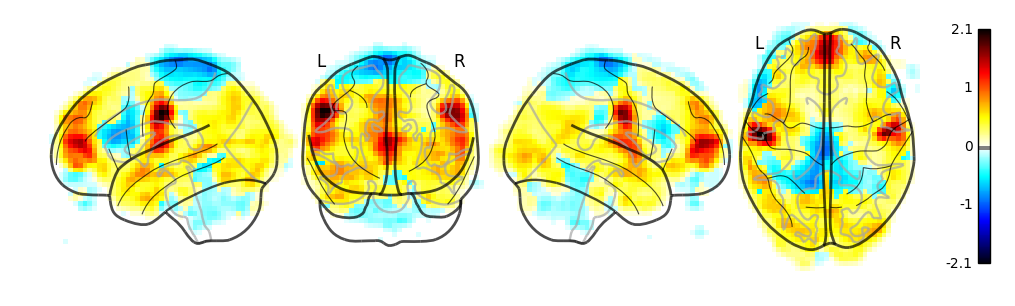

In [22]:
nilearn.plotting.plot_glass_brain(nilearn.image.mean_img(smooth_copes),
                                  display_mode='lyrz', 
                                  colorbar=True, 
                                  plot_abs=False)

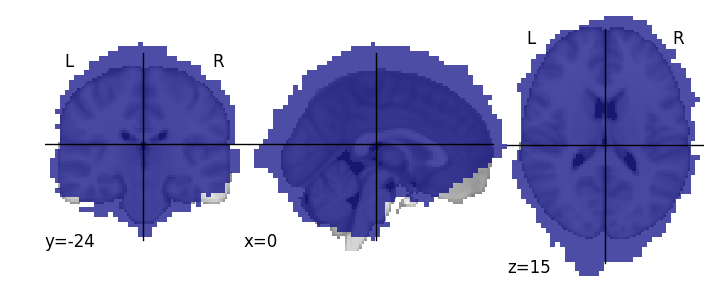

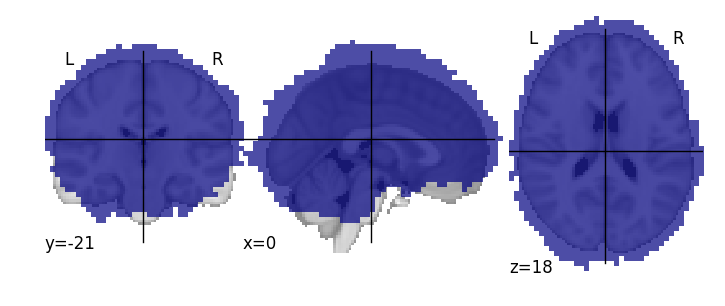

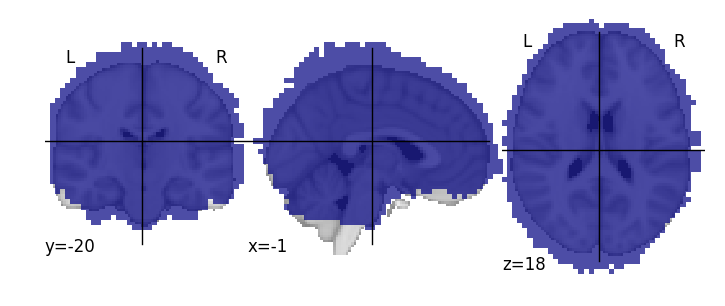

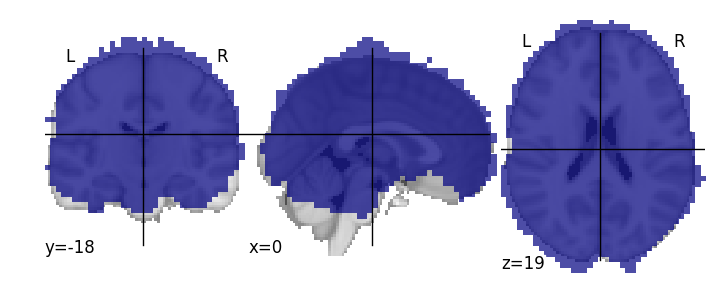

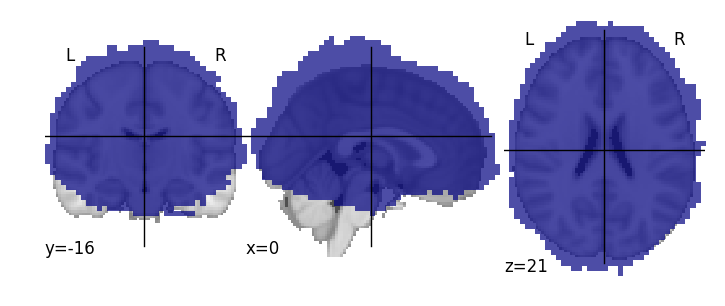

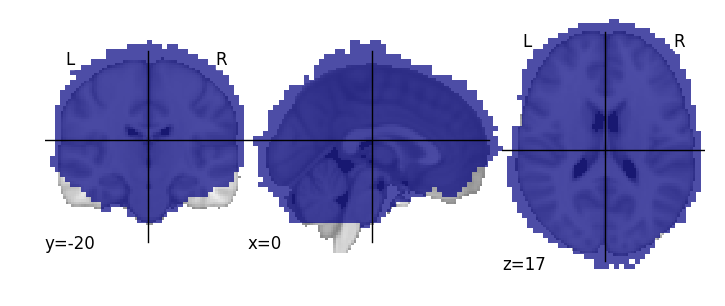

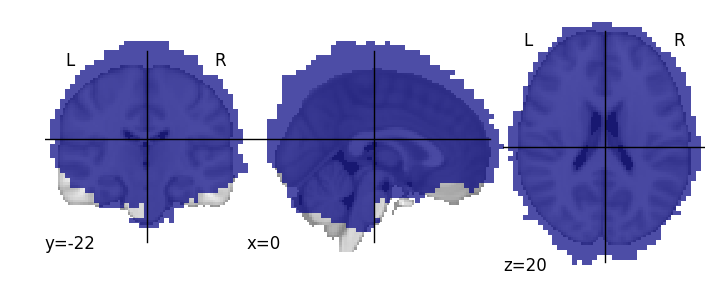

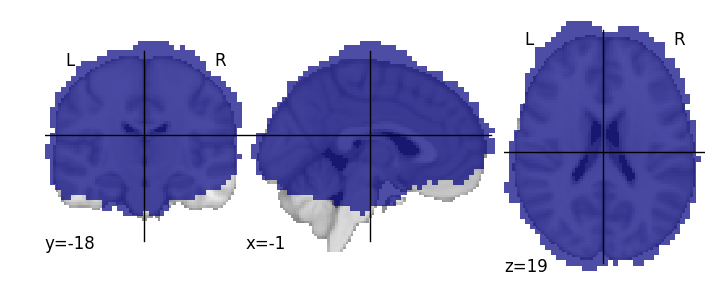

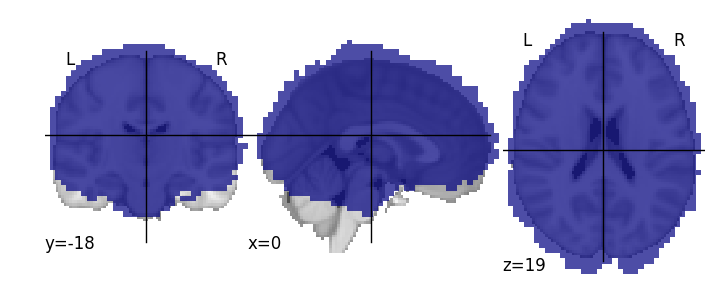

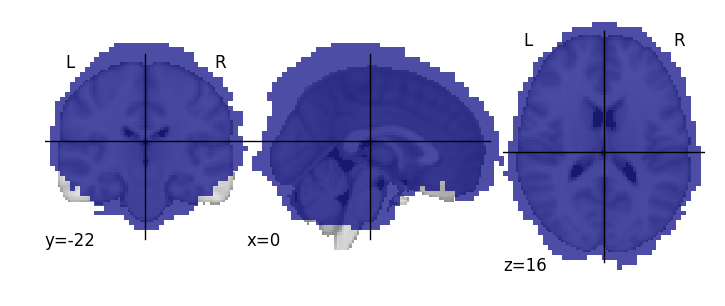

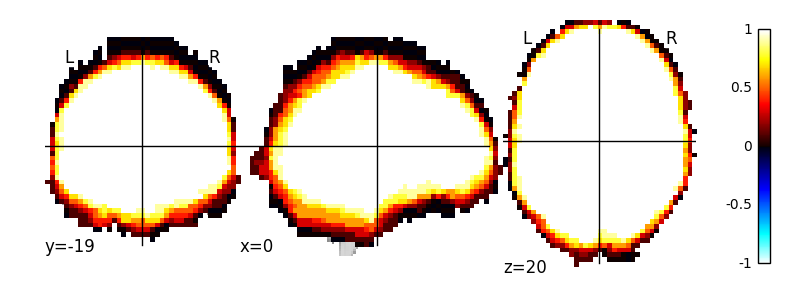

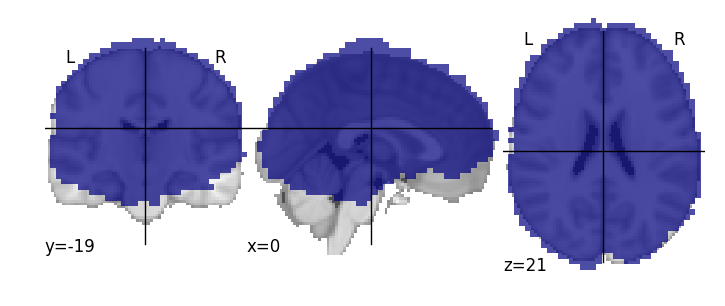

In [23]:
brainmasks = glob.glob(os.path.join(datadir, "derivatives", "fmriprep", "sub-*", "ses-test", "func", "*task-fingerfootlips_*space-MNI152NLin2009cAsym*_brainmask.nii*"))

for mask in brainmasks:
    nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

In [25]:
!mkdir -p {datadir}/derivatives/custom_modelling_spm/

copes_concat = nilearn.image.concat_imgs(smooth_copes, auto_resample=True)
copes_concat.to_filename(os.path.join(datadir, "derivatives", "custom_modelling_spm", "lips_vs_others_copes.nii.gz"))

group_mask = nilearn.image.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask.to_filename(os.path.join(datadir, "derivatives", "custom_modelling_spm", "group_mask.nii.gz"))

/home/vagrant/miniconda3/lib/python3.5/site-packages/nilearn/_utils/niimg_conversions.py:144: UserWarning: Affine is different across subjects. Realignement on first subject affine forced
  warnings.warn('Affine is different across subjects.'


In [27]:
randomise = mem.cache(fsl.Randomise)
randomise_results = randomise(in_file=os.path.join(datadir, "derivatives", "custom_modelling_spm", "lips_vs_others_copes.nii.gz"),
                              mask=os.path.join(datadir, "derivatives", "custom_modelling_spm", "group_mask.nii.gz"),
                              one_sample_group_mean=True,
                              tfce=True,
                              vox_p_values=True,
                              num_perm=500)
randomise_results.outputs

170216-19:13:50,390 workflow INFO:
	 Executing node bd4540e89d346b9cada734078daa2af6 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/bd4540e89d346b9cada734078daa2af6
170216-19:13:50,401 workflow INFO:
	 Running: randomise -i /media/sf_ds000114_R2.0.1/derivatives/custom_modelling_spm/lips_vs_others_copes.nii.gz -o "tbss_" -m /media/sf_ds000114_R2.0.1/derivatives/custom_modelling_spm/group_mask.nii.gz -n 500 -1 -T -x
170216-19:13:50,448 interface INFO:
	 stdout 2017-02-16T19:13:50.448118:randomise options: -i /media/sf_ds000114_R2.0.1/derivatives/custom_modelling_spm/lips_vs_others_copes.nii.gz -o tbss_ -m /media/sf_ds000114_R2.0.1/derivatives/custom_modelling_spm/group_mask.nii.gz -n 500 -1 -T -x 
170216-19:13:50,951 interface INFO:
	 stdout 2017-02-16T19:13:50.950940:Loading Data: 
170216-19:13:50,951 interface INFO:
	 stdout 2017-02-16T19:13:50.950940:Data loaded
170216-19:13:50,952 interface INFO:
	 stdout 2017-02-16T19:13:5


f_corrected_p_files = []
f_p_files = []
fstat_files = []
t_corrected_p_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/bd4540e89d346b9cada734078daa2af6/tbss__tfce_corrp_tstat1.nii.gz']
t_p_files = []
tstat_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Randomise/bd4540e89d346b9cada734078daa2af6/tbss__tstat1.nii.gz']

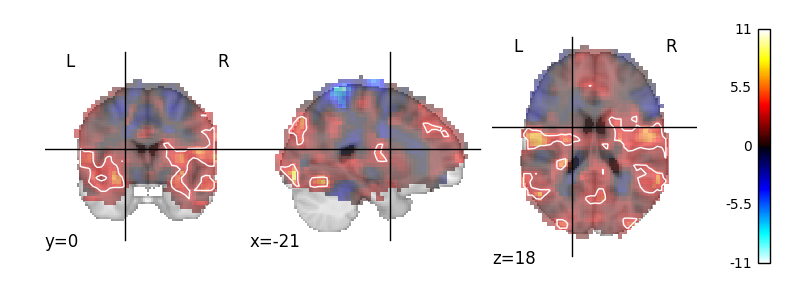

In [29]:
fig = nilearn.plotting.plot_stat_map(randomise_results.outputs.tstat_files[0], alpha=0.5, cut_coords=(-21, 0, 18))
fig.add_contours(randomise_results.outputs.t_corrected_p_files[0], levels=[0.95], colors='w')